## Settings

In [1]:
import warnings
import os
import sys
from sys import platform
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config
from utils import get_ds_statistics, get_model_type

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, accuracy_score, precision_score, recall_score, f1_score

/home/fontana/Tesi/recsost_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_config = get_global_config()

DATA_PATH = os.path.join(BASE_PATH, _config.get('DATASET_PATH'))
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH_SHARED'))
DATASET_FILE = os.path.join(BASE_PATH, _config.get('DATASET_FILE'))
DATASET_AZURE_FILE = os.path.join(BASE_PATH, _config.get('DATASETAZURE_FILE'))
if platform == 'win32':
	DATA_PATH = DATA_PATH.replace('/', '\\')
	RESULTS_PATH = RESULTS_PATH.replace('/', '\\')
	DATASET_FILE = DATASET_FILE.replace('/', '\\')
	DATASET_AZURE_FILE = DATASET_AZURE_FILE.replace('/', '\\')
EMISSIONS_FILE = 'emissions.csv'
METRICS_FILE = 'metrics.csv'
PARAMS_FILE = 'params.csv'

In [43]:
data = pd.DataFrame({
	# Related to dataset
    'n_users': [],
    'n_items': [],
    'n_inter': [],
    'sparsity': [],

    # Related to KG dataset
	'kg_entities': [],
	'kg_relations': [],
	'kg_triples': [],
	'kg_items': [],

	# Related to hardware
    'cpu_cores': [],
    'ram_size': [],
    'is_gpu': [],

	# Related to model
	'model_name': [],
    'model_type': [],
    

	# Label
	'emissions': []
})

## Features extraction

In [44]:
experiments = []
for d in next(os.walk(RESULTS_PATH))[1]:
	for m in next(os.walk(RESULTS_PATH + d))[1]:
		experiments.append(os.path.join(d, m))
experiments = sorted(experiments)

In [45]:
for i, v in enumerate(experiments):
	e = pd.read_csv(os.path.join(RESULTS_PATH, v, EMISSIONS_FILE))

	e = e[e['country_iso_code'] == 'NLD']
 
	dataset = v.split("/")[0]
	model = v.split("/")[1]
	stats = get_ds_statistics(os.path.join(DATA_PATH, dataset))
	for _, row in e.iterrows():
		data.loc[len(data)] = [
			stats['n_users'],
			stats['n_items'],
			stats['n_inter'],
			stats['sparsity'],
			stats['kg_entities'],
			stats['kg_relations'],
			stats['kg_triples'],
			stats['kg_items'],
			row['cpu_count'],
			row['ram_total_size'],
			row['gpu_count'] if row['gpu_count'] == 1. else .0,
			model,
			get_model_type(model),
			row['emissions'],
		]

In [135]:
data.sample(n=5)

,n_users,n_items,n_inter,sparsity,kg_entities,kg_relations,kg_triples,kg_items,cpu_cores,ram_size,is_gpu,model_name,model_type,emissions
192,6040,3706,1000209,0.955316,79347,49,385923,3655,12,64.000000,1.0,11,0,0.001356
314,23679,4414,1048575,0.989968,0,0,0,0,4,27.405815,1.0,BPR,general,0.004162
77,22155,54458,1465871,0.998785,26315,16,96476,11446,12,64.000000,1.0,16,1,0.000956
185,6040,3706,1000209,0.955316,79347,49,385923,3655,4,27.405815,1.0,7,0,0.001998
279,19841,33653,440620,0.999340,42031,5,38491,816701,4,27.405804,1.0,CFKG,knowledge,0.004978


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 90
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   n_users       91 non-null     int64  
 1   n_items       91 non-null     int64  
 2   n_inter       91 non-null     int64  
 3   sparsity      91 non-null     float64
 4   kg_entities   91 non-null     int64  
 5   kg_relations  91 non-null     int64  
 6   kg_triples    91 non-null     int64  
 7   kg_items      91 non-null     int64  
 8   cpu_cores     91 non-null     int64  
 9   ram_size      91 non-null     float64
 10  is_gpu        91 non-null     float64
 11  model_name    91 non-null     object 
 12  model_type    91 non-null     object 
 13  emissions     91 non-null     float64
dtypes: float64(4), int64(8), object(2)
memory usage: 10.7+ KB


In [47]:
# UNCOMMENT TO SAVE CSV DATASET
#if not os.path.isfile(DATASET_FILE):
 #	os.unlink(DATASET_FILE)
data.to_csv(DATASET_AZURE_FILE, index=False, encoding='utf-8')

## Preprocessing

In [3]:
data = pd.read_csv(DATASET_FILE ,encoding='utf-8')
#sort data by emissions in ascending order
data = data.sort_values(by='emissions')
#data = data.iloc[:-8]
data = data.sort_index()

data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 265 entries, 0 to 264
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   n_users       265 non-null    int64  
 1   n_items       265 non-null    int64  
 2   n_inter       265 non-null    int64  
 3   sparsity      265 non-null    float64
 4   kg_entities   265 non-null    int64  
 5   kg_relations  265 non-null    int64  
 6   kg_triples    265 non-null    int64  
 7   kg_items      265 non-null    int64  
 8   cpu_cores     265 non-null    int64  
 9   ram_size      265 non-null    float64
 10  is_gpu        265 non-null    float64
 11  model_name    265 non-null    object 
 12  model_type    265 non-null    object 
 13  emissions     265 non-null    float64
dtypes: float64(4), int64(8), object(2)
memory usage: 31.1+ KB


In [4]:
# Null values check
data.isnull().any()

for col in data.columns:
    print(f'{col}: {data[col].unique()}')

n_users: [19841 22155 23679 50000  6040]
n_items: [42457 24878 33653 38932 54458  4414 10000  3706]
n_inter: [ 900212  218457  440620  667850 1465871 1048575 7053774 1000209]
sparsity: [0.99893136 0.99955742 0.9993401  0.99913541 0.99878504 0.98996762
 0.98589245 0.95531637]
kg_entities: [ 50665  32907  42031  47308  26315      0 175646  79347]
kg_relations: [ 5 16  0 31 49]
kg_triples: [ 46827  29822  38491  43559  96476      0 521125 385923]
kg_items: [816701  11446      0  10601   3655]
cpu_cores: [ 4 12]
ram_size: [27.40580368 64.         16.         27.40581512]
is_gpu: [1. 0.]
model_name: ['BPR' 'CFKG' 'CKE' 'DGCF' 'DMF' 'ItemKNN' 'KGCN' 'KGNNLS' 'LINE'
 'LightGCN' 'MultiDAE' 'NGCF' 'RippleNet' 'CDAE' 'DiffRec' 'ENMF' 'FISM'
 'GCMC' 'KGIN' 'KTUP' 'LDiffRec' 'MKR' 'MacridVAE' 'MultiVAE' 'NCEPLRec'
 'NCL' 'NeuMF' 'Pop' 'Random' 'RecVAE' 'SGL' 'SLIMElastic' 'SimpleX'
 'SpectralCF' 'EASE' 'NAIS' 'ADMMSLIM' 'ConvNCF' 'NNCF']
model_type: ['general' 'knowledge']
emissions: [2.16764693e-

In [5]:
# Turn categorical features into numerical
data.loc[data['model_type'] == 'general', 'model_type'] = 0
data.loc[data['model_type'] == 'knowledge', 'model_type'] = 1
mymap = sorted(list(set(data['model_name'])))
for _, v in enumerate(mymap):
	data.loc[data['model_name'] == v, 'model_name'] = mymap.index(v)


In [6]:
# Turn continuous output values into discrete values
interval = (data['emissions'].max() + data['emissions'].min()) / 3
low_bound = data['emissions'].min() + interval
#low_mid_bound = data['emissions'].min() + 2*interval
high_bound = data['emissions'].max() - interval
#high_mid_bound = data['emissions'].max() - 2*interval

data_class = data.copy()
#print(low_bound, low_mid_bound, high_mid_bound, high_bound)



#data_class.loc[data_class['emissions'] >= high_bound, 'emissions'] = 2
#data_class.loc[(data_class['emissions'] > low_bound) & (data_class['emissions'] < high_bound), 'emissions'] = 1
#data_class.loc[data_class['emissions'] <= low_bound, 'emissions'] = 0


data_class.loc[data_class['emissions'] >= high_bound, 'emissions'] = 2
#data_class.loc[(data_class['emissions'] >= high_mid_bound) & (data_class['emissions'] < high_bound), 'emissions'] = 3
#data_class.loc[(data_class['emissions'] >= low_mid_bound) & (data_class['emissions'] <high_mid_bound ), 'emissions'] = 2
data_class.loc[(data_class['emissions'] >= low_bound) & (data_class['emissions'] < high_bound), 'emissions'] = 1
data_class.loc[data_class['emissions'] < low_bound, 'emissions'] = 0

In [7]:
data_class.emissions.value_counts()

emissions
0.0    262
2.0      2
1.0      1
Name: count, dtype: int64

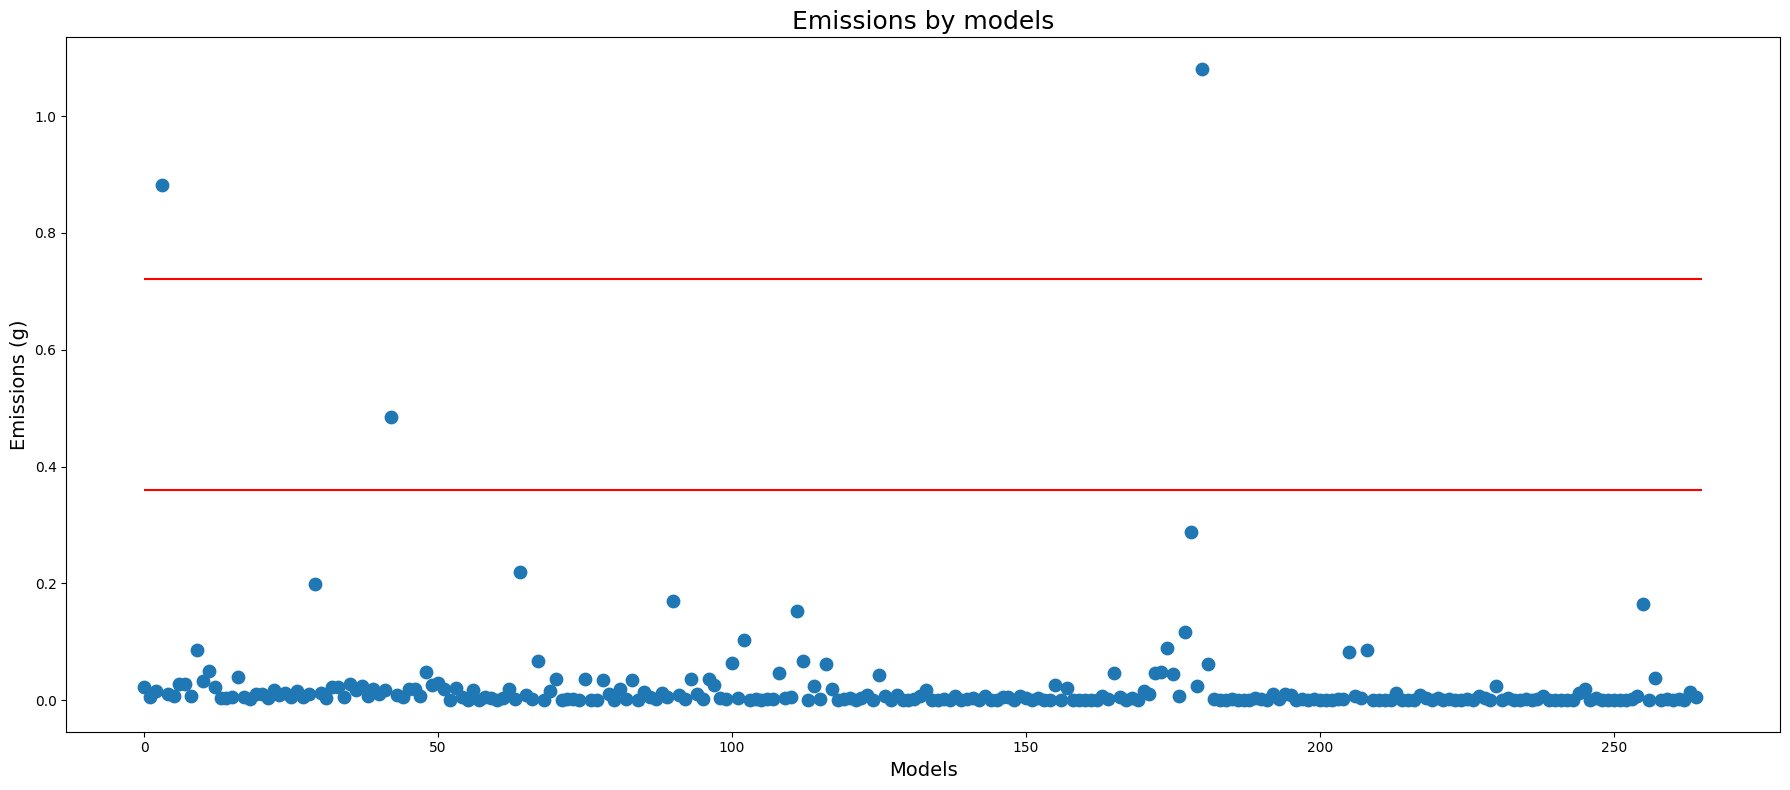

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(18, 8))
axs.scatter(range(len(data['emissions'])), data['emissions'], s=80)
axs.hlines(low_bound, 0, len(data['emissions']), colors='r')
#axs.hlines(low_mid_bound, 0, len(data['emissions']), colors='r')
#axs.hlines(high_mid_bound, 0, len(data['emissions']), colors='r')
axs.hlines(high_bound, 0, len(data['emissions']), colors='r')
axs.set_title('Emissions by models', fontsize=18)
axs.set_xlabel('Models', fontsize=14)
axs.set_ylabel('Emissions (g)', fontsize=14)
fig.tight_layout()
plt.show()

## Models definition

In [61]:
X = data.loc[:, data.columns != 'emissions']
y = data[['emissions']]
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype('float64'),
    y.values.astype('float64'),
    train_size = .7,
    test_size = .3,
    random_state = 2,
    shuffle = True
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

REGRESSOR                MAE              RMSE              MSLE

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

SVR                 0.1103392         0.0268736         0.0154947


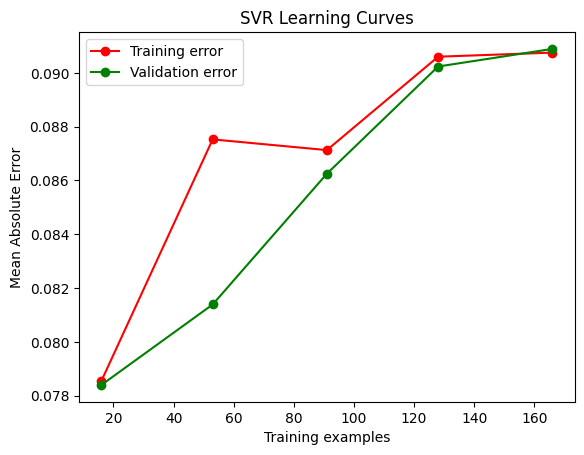


DECISION TREE       0.0419923         0.0139534         0.0067713


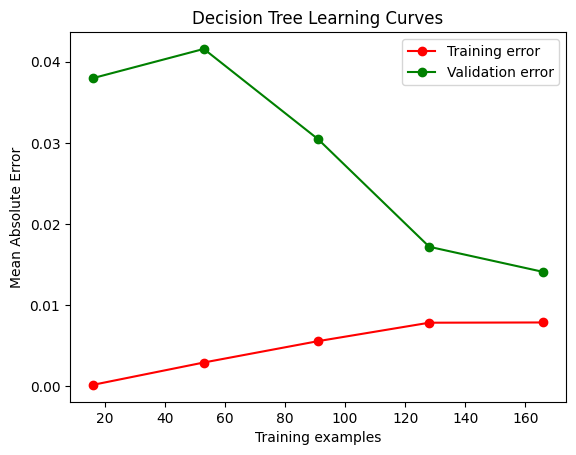


RANDOM FOREST       0.0410102         0.0179366         0.0081916


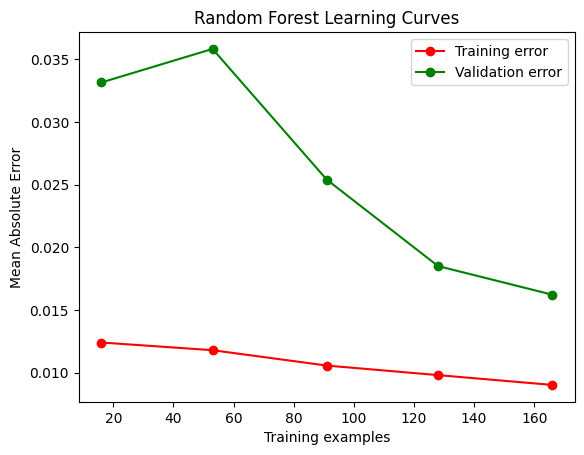


ADABOOST            0.0486434         0.0160941         0.0074143


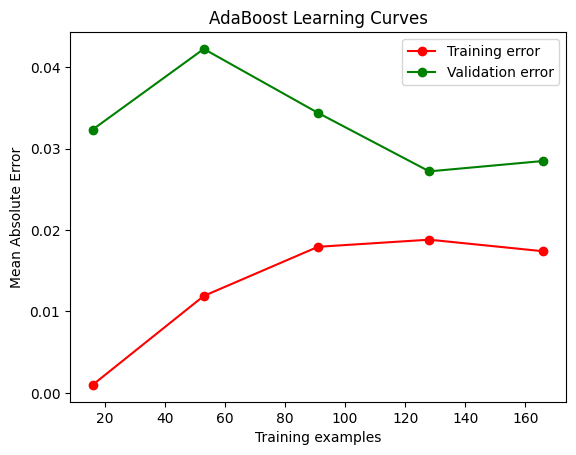

In [62]:
print(''.join(['> ' for i in range(35)]))
print(f'\n{"REGRESSOR":<20}{"MAE":>8}{"RMSE":>18}{"MSLE":>18}\n')
print(''.join(['> ' for i in range(35)]))

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

model_SVR = SVR()
model_SVR.fit(X_train, y_train)
pred = model_SVR.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"SVR":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')





train_sizes, train_scores, test_scores = learning_curve(model_SVR, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('SVR Learning Curves')
plt.show()



model_DecisionTree = DecisionTreeRegressor(max_depth=5, random_state=3)
model_DecisionTree.fit(X_train, y_train)
pred = model_DecisionTree.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"DECISION TREE":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')


train_sizes, train_scores, test_scores = learning_curve(model_DecisionTree, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('Decision Tree Learning Curves')
plt.show()

model_RandomForest = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=3)
model_RandomForest.fit(X_train, y_train)
pred = model_RandomForest.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"RANDOM FOREST":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')


train_sizes, train_scores, test_scores = learning_curve(model_RandomForest, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('Random Forest Learning Curves')
plt.show()


model_AdaBoost = AdaBoostRegressor(n_estimators=500, random_state=3)
model_AdaBoost.fit(X_train, y_train)
pred = model_AdaBoost.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"ADABOOST":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

train_sizes, train_scores, test_scores = learning_curve(model_AdaBoost, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('AdaBoost Learning Curves')
plt.show()



In [63]:
def calculateError(path,columnsName,X_test,y_test,model,low_bound,high_bound):
    results = pd.DataFrame(columns=columnsName)
    for i in range(len(columnsName)):
        results[columnsName[i]] = X_test[:,i]
    results['real_value'] = y_test
    results['predicted_value'] = model.predict(X_test)
    results['abs_error'] = abs(results['real_value'] - results['predicted_value'])
    results['percentage_error'] = abs(results['abs_error']/results['real_value'])
    results['class'] = 0
    results.loc[results['real_value'] >= high_bound, 'class'] = 2
    results.loc[(results['real_value'] >= low_bound) & (results['real_value'] < high_bound), 'class'] = 1
    results.to_csv(path, index=False, encoding='utf-8')
    return results
    

In [66]:
def calculateMeanError(path,low_bound,high_bound):
    results = pd.read_csv(path,encoding='utf-8')
    print("high_bound",high_bound)
    print("low_bound",low_bound)
    print("Number of samples for each class")
    print(results['class'].value_counts())
    print("Mean of the percentage error for each class")
    print(results.groupby('class')['percentage_error'].mean())
    print("Mean of the absolute error for each class")
    print(results.groupby('class')['abs_error'].mean())

    

In [69]:
data.info()
columns=data.columns
columns=columns.drop('emissions')
calculateError("data/dataset_RandomForest.csv",columns,X_test,y_test,model,low_bound,high_bound)
calculateMeanError("data/dataset_RandomForest.csv",low_bound,high_bound)


<class 'pandas.core.frame.DataFrame'>
Index: 265 entries, 0 to 264
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   n_users       265 non-null    int64  
 1   n_items       265 non-null    int64  
 2   n_inter       265 non-null    int64  
 3   sparsity      265 non-null    float64
 4   kg_entities   265 non-null    int64  
 5   kg_relations  265 non-null    int64  
 6   kg_triples    265 non-null    int64  
 7   kg_items      265 non-null    int64  
 8   cpu_cores     265 non-null    int64  
 9   ram_size      265 non-null    float64
 10  is_gpu        265 non-null    float64
 11  model_name    265 non-null    object 
 12  model_type    265 non-null    object 
 13  emissions     265 non-null    float64
dtypes: float64(4), int64(8), object(2)
memory usage: 31.1+ KB
high_bound 0.7205403996360675
low_bound 0.36027045739563296
Number of samples for each class
class
0    78
2     2
Name: count, dtype: int64
Mean of 

In [26]:
X = data_class.loc[:, data_class.columns != 'emissions']
y = data_class[['emissions']]
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype('float64'),
    y.values.astype('float64'),
    train_size = .7,
    test_size = .3,
    random_state = 2,
    shuffle = True,
	stratify=y
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [24]:
print(''.join(['> ' for i in range(42)]))
print(f'\n{"CLASSIFIER":<20}{"ACCURACY":>8}{"PRECISION":>18}{"RECALL":>18}{"F1_SCORE":>18}\n')
print(''.join(['> ' for i in range(42)]))
warnings.filterwarnings('ignore')
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro', labels=np.unique(pred))
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"SVR":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

model = DecisionTreeClassifier(max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"DECISION TREE":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"RANDOM FOREST":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

model = AdaBoostClassifier(n_estimators=20, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"ADABOOST":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

CLASSIFIER          ACCURACY         PRECISION            RECALL          F1_SCORE

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

SVR                     0.90              0.33              0.90              0.32

DECISION TREE           0.90              0.33              0.30              0.32

RANDOM FOREST           0.88              0.33              0.31              0.32

ADABOOST                0.74              0.67              0.72              0.60
